





# Import Necessary Packages

In [0]:
import json
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_decomposition import CCA
from ReClass2 import Subject, TSModel
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import shutil
import os
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
import gc
start = time.time()

# Import data from .mat file

In [0]:
#Only run this cell if the user has access to a GPU
#Flushes out memory to ensure faster model building
def reset_keras():
  sess=K.tensorflow_backend.get_session()
  K.tensorflow_backend.clear_session()
  sess.close()
  sess=K.tensorflow_backend.get_session()
  
  try:
    del classifier
  except:
    pass
  gc.collect()
  
  config = tf.ConfigProto()
  config.gpu_options.per_process_gpu_memory_fraction = 1
  config.gpu_options.visible_device_list = "0"
  K.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
#Save the models and weights to local machine
def save_model(i, models):
  count = 1
  state = ""
  if i == 0: 
    state = "NC"
  elif i == 1:
    state = "MCI"
  else:
    state = "AD"
  for model in models[i].chModel:
    model_json = model.to_json()
    with open("model-%d-%s.json" % (count, state), "a+") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model-%d-%s.h5" % (count, state))
    count += 1
    print("Saved model to disk")

if __name__ == '__main__':
  
  subjects = [] #Creating a list of Subject classes to keep track of participant information
  
  #separate the .mat files needed from the directories
  subjectData = sorted(glob.glob('/content/drive/My Drive/Spark-2019/AD_MCI_Data/reformated data/resting data/extracted data 30chns/rest1 1min/rec*.mat'))#+ glob.glob('rec??.mat'))
  subjectData = [x[109:] for x in subjectData]
  print(subjectData)
  
  #Loop through each file and save the subjects data, state, and channels in a Class Object
  for index,value in enumerate(subjectData):
      
      subjects.append(Subject(loadmat('/content/drive/My Drive/Spark-2019/AD_MCI_Data/reformated data/resting data/headerInfo/'+value)['dx'][0],\
                              loadmat('/content/drive/My Drive/Spark-2019/AD_MCI_Data/reformated data/resting data/extracted data 30chns/rest1 1min/'+value)['data'],\
                              index))

['rec1.mat', 'rec11.mat', 'rec12.mat', 'rec13.mat', 'rec14.mat', 'rec16.mat', 'rec17.mat', 'rec18.mat', 'rec19.mat', 'rec2.mat', 'rec20.mat', 'rec21.mat', 'rec22.mat', 'rec23.mat', 'rec24.mat', 'rec25.mat', 'rec3.mat', 'rec33.mat', 'rec36.mat', 'rec39.mat', 'rec4.mat', 'rec5.mat', 'rec51.mat', 'rec52.mat', 'rec53.mat', 'rec54.mat', 'rec55.mat', 'rec57.mat', 'rec6.mat', 'rec60.mat', 'rec61.mat', 'rec62.mat', 'rec66.mat', 'rec68.mat', 'rec69.mat', 'rec7.mat', 'rec70.mat', 'rec71.mat', 'rec72.mat', 'rec73.mat', 'rec74.mat', 'rec75.mat', 'rec76.mat', 'rec77.mat', 'rec78.mat', 'rec8.mat', 'rec85.mat', 'rec9.mat']
-----time in seconds: 7.873445 s-----


# Build models using leave-one-out principle

In [0]:
  """
  for j in record:
      Assemble the other 47 subjects into training sets based on their cognitive state -> NC, MCI, AD
      for i in channels:
          Build a reconstruction model for the current channel i using the other 29 channels
          Calculate the quality scores for channel i using the developed models for NC, MCI, and AD
      Rearrange the calculated quality scores for record j in the order of q1-q30 for each model
  """
  #Use leave-one-out priniciple for training validation
  loo = LeaveOneOut()
  models = []
  #Separate data into three training sets based on cognitive state
  models.append(TSModel([x for x in subjects if x.cogState == 'N']))
  models.append(TSModel([x for x in subjects if x.cogState == 'MCI']))
  models.append(TSModel([x for x in subjects if x.cogState == 'AD']))
  

In [0]:
  #Train the three training set models to avoid rebuilding them for future use
  models[0].trainMatrixModel("NC")
  models[1].trainMatrixModel("MCI")
  models[2].trainMatrixModel("AD")

In [0]:
for train, test in loo.split(models[0].cogStates): 
    #Train a new model for each subject in the training set using the data from the n other subjects in the set
    NC_TR = TSModel([x for x in models[0].cogStates if x.cogState == 'N' and models[0].cogStates.index(x) != test])
    NC_TR.trainModel()
    
    #Make predictions for how well the original data fits the model
    NC_TR.predictModels(models[0].cogStates[int(test)])
    trained_models[1].predictModels(models[0].cogStates[int(test)])
    trained_models[2].predictModels(models[0].cogStates[int(test)])
    
    #Calculate the correlation coefficient for the original and reconstructed model to determine the strength
    #of the relationship between the two signals
    NC_TR.calc_CCof(models[0].cogStates[int(test)], "NC")
    trained_models[1].calc_CCof(models[0].cogStates[int(test)], "MCI")
    trained_models[2].calc_CCof(models[0].cogStates[int(test)], "AD")
    
    #Only use this function if there is access to the GPU
    #K.clear_session()

# Gather Correlation Coefficients and create a Correlation Matrix

In [0]:
#Absolute path is dependent on where the files are located in the user's local machine
sub = sorted(glob.glob("/content/drive/My Drive/Spark-2019/Subject Data/Sub-?.txt")) + sorted(glob.glob("/content/drive/My Drive/Spark-2019/Subject Data/Sub-??.txt"))
NC=[]
MCI=[]
AD=[]
i=0

#loop through each subject's file containing correlation coefficient data
#Build the 48x90 matrix organizing the rows into the subject indices
#and organizing the columns in the following order: first 30 are NC,
#next 30 are MCI, last 30 are AD
for file in sub:
  with open(file, "r") as f:
    
    x = f.readlines()
    check = 0
    
    for y in x:
      if y != '\n' and y[0] != '-':
        check = 0
        y = y.split()
        if 'NC-Model' in y:
          pass
        elif 'MCI-Model' in y:
          check = 1
        elif 'AD-Model' in y: 
          check = 2
      elif y != '\n' and y[0] == '-':
        y = y.split()[1].strip(',').strip('(')
        if check == 0:
          NC.append(y)
        elif check == 1:
          MCI.append(y)
        else:
          AD.append(y)
  if i == 0:
    cof_matrix = np.asarray([NC+MCI+AD])
    i += 1
  else:
    s = np.asarray(NC+MCI+AD)
    cof_matrix = np.append(cof_matrix, [s], axis = 0)
  
  NC.clear()
  MCI.clear()
  AD.clear()
  

# Use PCA and Plot Principle Components

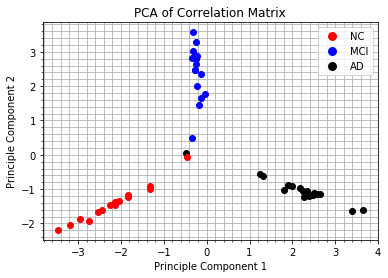

In [0]:
#Perform PCA on the data and plot the results on the xy-plane
pca = PCA(n_components=2)
dataset = pca.fit_transform(cof_matrix)

NC_index = [x.index for x in models[0].cogStates]
MCI_index = [x.index for x in models[1].cogStates]
AD_index = [x.index for x in models[2].cogStates]
  
  
legend_elements = [Line2D([0], [0], marker='o', color='w', label='NC',
                          markerfacecolor='r', markersize=10), 
                   Line2D([0], [0], marker='o', color='w', label='MCI',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='AD',
                          markerfacecolor='k', markersize=10)]
  
  
plt.figure()
plt.minorticks_on()
plt.grid(True, 'both')
for i,v in enumerate(dataset):

  if i in NC_index:
    plt.plot(v[0], v[1], 'ro') 
  elif i in MCI_index:
    plt.plot(v[0], v[1], 'bo')
  elif i in AD_index:
    plt.plot(v[0], v[1], 'ko')
    
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2') #for each component
plt.title('PCA of Correlation Matrix')
plt.legend(handles=legend_elements, loc='upper right')
fig1 = plt.gcf()
plt.show()
fig1.savefig('Correlation-PCA.png', bbox_inches='tight')

# Classify using an SVM Model

In [0]:
#Perform SVM on the reduced data from above
def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear'))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])

    plt.scatter(X[:, 0], X[:, 1], s=80, marker='^', label='MCI',linewidth='2', edgecolor='black')
    
    plt.scatter(X[zero_class, 0], X[zero_class, 1],s=150, marker = 's', label='AD',linewidth='2', edgecolor='black')
    
    plt.scatter(X[one_class, 0], X[one_class, 1], s=150, label='NC',linewidth='2', edgecolor='black')

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class MCI & AD')
    plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class NC & MCI')

    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper left")


plt.figure(figsize=(32, 24))

plot_subfigure(x, np.reshape(y,(-1,2)), 1, "With labeled samples + PCA", "pca")